In [1]:
import os, sys, glob, json, contextlib
import librosa
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader

sys.path.append("..")
# deal with a known bug in sklearn that pollutes stdout: https://stackoverflow.com/questions/52596204/the-imp-module-is-deprecated
with contextlib.redirect_stderr(None):
    from sklearn import metrics
    from sklearn.manifold import TSNE

In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
%aimport src.dataloader
%aimport train
%aimport src.model 
import src.params
from IPython.display import display, Audio

# Evaluating on WHOIS dev set

This is just a held-out subsample of the scraped WHOIS dataset. Most of the negative examples are from a single master tape (60012), as a large portion of the data only consisted of short clips containing only positive examples of Orca vocalizations. 

Loaded mean and invstd from: ../train_data/mean64.txt ../train_data/invstd64.txt
Loading file: 60012.wav
Loading file: 92303001.wav
Loading file: 92303002.wav
Loading file: 92303003.wav
Loading file: 92303004.wav
Loading file: 92303005.wav
Loading file: 92303006.wav
Loading file: 92303007.wav
Loading file: 92303008.wav
Loading file: 92303009.wav
Loading file: 9230300A.wav
Loading file: 9230300B.wav
Loading file: 9230300C.wav
Loading file: 9230300D.wav
Loading file: 9230300E.wav
Loading file: 9230300F.wav
Loading file: 97745001.wav
Loading file: 97745002.wav
Loading file: 97745003.wav
Loading file: 97745004.wav
Loading file: 97745005.wav
Loading file: 97745006.wav
Loading file: 97753001.wav
Loading file: 97753002.wav
Loading file: 97753003.wav
Loading file: 97753004.wav
Loading file: 97753005.wav
Loading file: 97753006.wav
Loading file: 97753007.wav
Loading file: 97753008.wav
Loading file: 97753009.wav
Loading file: 9775300A.wav
Loading file: 9775300B.wav
Loading file: 9775300C.wav
Load

<IPython.core.display.Javascript object>


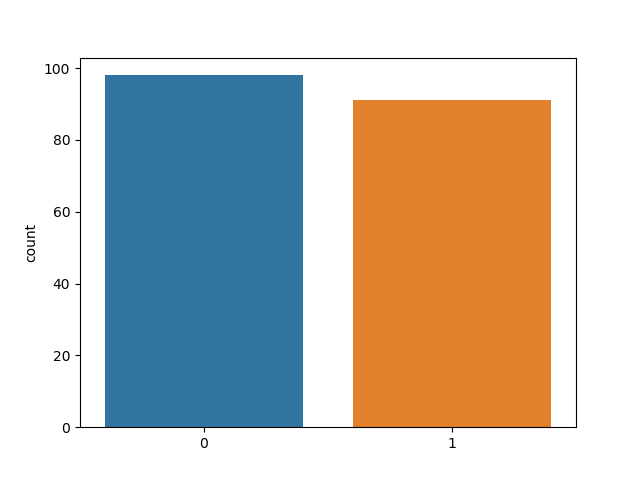

In [31]:
dev_dataset = src.dataloader.AudioFileDataset(
    "../train_data/wav","../train_data/dev.tsv",mean="../train_data/mean64.txt",invstd="../train_data/invstd64.txt"
)
dev_dataloader = DataLoader(dev_dataset, batch_size=1, shuffle=False, drop_last=False)
print("Total dataset size:",len(dev_dataset))
labels = [l[2] for l in dev_dataset.windows]
sns.countplot(labels)

In [32]:
net, curr_epoch = src.model.get_model_or_checkpoint("AudioSet_fc_all","../runs/AudioSet_fc_all_run3/",1,epoch=8)
net = net.eval()
scores = []
preds = []
targets = []

for i, (data,target) in enumerate(dev_dataloader):
    data, target = data.unsqueeze(1).float().cuda(), target.cuda() 
    logposterior, _ = net(data)
    scores.append(np.exp(logposterior.detach().cpu().numpy())[0,-1])
    targets.append(target.cpu().item()) 

Loaded checkpoint: ../runs/AudioSet_fc_all_run3\AudioSet_fc_all_Iter_8


In [33]:
fpr, tpr, thresholds = metrics.roc_curve(targets,scores)
auc = metrics.auc(fpr,tpr)
print("AUC: {:.3f}".format(auc))

AUC: 0.907


<IPython.core.display.Javascript object>


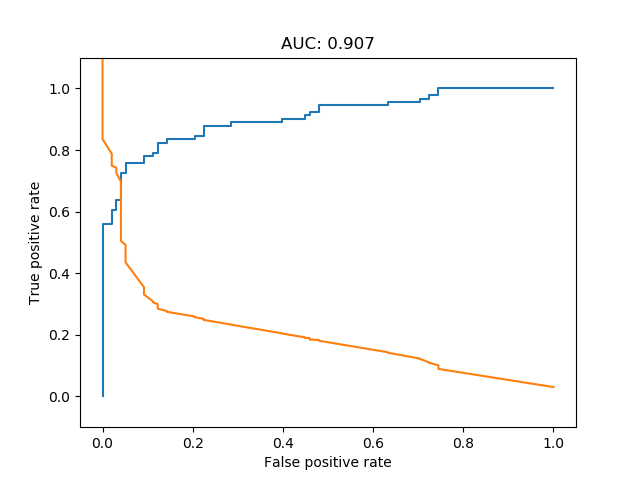

In [34]:
%matplotlib notebook
plt.plot(fpr,tpr)
plt.plot(fpr,thresholds)
plt.ylim((-0.1,1.1))
_ = plt.xlabel("False positive rate")
_ = plt.ylabel("True positive rate")
_ = plt.title("AUC: {:.3f}".format(auc))

In [39]:
threshold = 0.25 # threshold to pick when generating annotation candidates (favours recall of postive examples)
preds = [ 1 if s > threshold else 0 for s in scores ]
print(metrics.classification_report(targets,preds))
print(metrics.confusion_matrix(targets,preds))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81        98
           1       0.78      0.86      0.82        91

   micro avg       0.81      0.81      0.81       189
   macro avg       0.82      0.82      0.81       189
weighted avg       0.82      0.81      0.81       189

[[76 22]
 [13 78]]


Based on the above, and trying a few threshold values and looking at the confusion matrix, the following seem like good operating points:
* For generating annotation candidates: 0.20. Favors high recall (0.90) of positive examples with a bit of loss of precision (0.67)
* For generating negative examples: 0.09. Favors high precision (0.96) for negative examples 

## Look at specific misclassifications

In [ ]:
fns = [ i for i in range(len(preds)) if (preds[i]==0) and (targets[i]==1) ]
fps = [ i for i in range(len(preds)) if (preds[i]==1) and (targets[i]==0) ]
for i in fns:
    print(i,dev_dataset.windows[i][:2],dev_dataset.windows[i][-1].name)

In [271]:
idx = np.random.choice(fns)
_, label = dev_dataset[idx]
print("Idx:",idx,"out of total",len(fns),"Label",label)
dev_dataset.get_mode = 'audio'
sample, label = dev_dataset[idx]
Audio(sample,rate=dev_dataset.sr)

Idx: 26 out of total 26 Label 1


(96, 64)


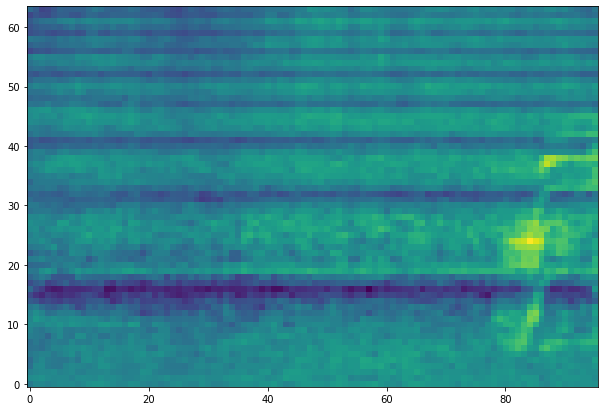

In [272]:
dev_dataset.get_mode = 'mel_spec'
mel_spec, label = dev_dataset[idx]
print(mel_spec.shape)
# plot the spectrogram
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
ax.imshow(mel_spec.T,origin='lower')

## Explore Audioset model embeddings

In [269]:
net, curr_epoch = model.get_model_or_checkpoint("AudioSet_fc_all","../runs/AudioSet_fc_all_run3/",1,epoch12)
net = net.eval()
embeds = np.zeros((len(dev_dataloader),128))
targets = np.zeros(len(dev_dataloader))
for i, (data,target) in enumerate(dev_dataloader):
    x = data.unsqueeze(1).float()
    embeds[i,:] = net(x)[1].squeeze().detach().cpu().numpy()
    targets[i] = target

Loaded checkpoint: ../runs/AudioSet_fc_all_run3\AudioSet_fc_all_Iter_12


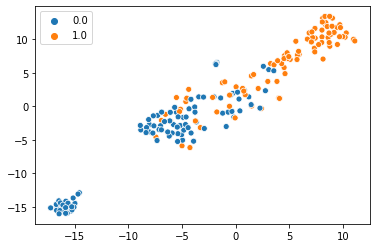

In [270]:
embeds_tsne = TSNE(n_components=2).fit_transform(embeds)
sns.scatterplot(embeds_tsne[:,0],embeds_tsne[:,1],hue=targets)

# Evaluate on Scott's field test set

This is ~30min of field recordings from the Orcasound lab hydrophone on July 07, 2019 that were annotated by Scott as one of the test sets to measure performance in more realistic condititions. The distribution of labels here is a bit atypical as it contains many more positive examples than negative. 

OS_9_27_2017_11_58_00__0003.wav: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 89.21it/s]


Loaded mean and invstd from: C:\Users\AKMAHAJA\Workspace\Hack\PodCast\data\TrainAll\mean64.txt C:\Users\AKMAHAJA\Workspace\Hack\PodCast\data\TrainAll\invstd64.txt
Total dataset size: 508


<IPython.core.display.Javascript object>


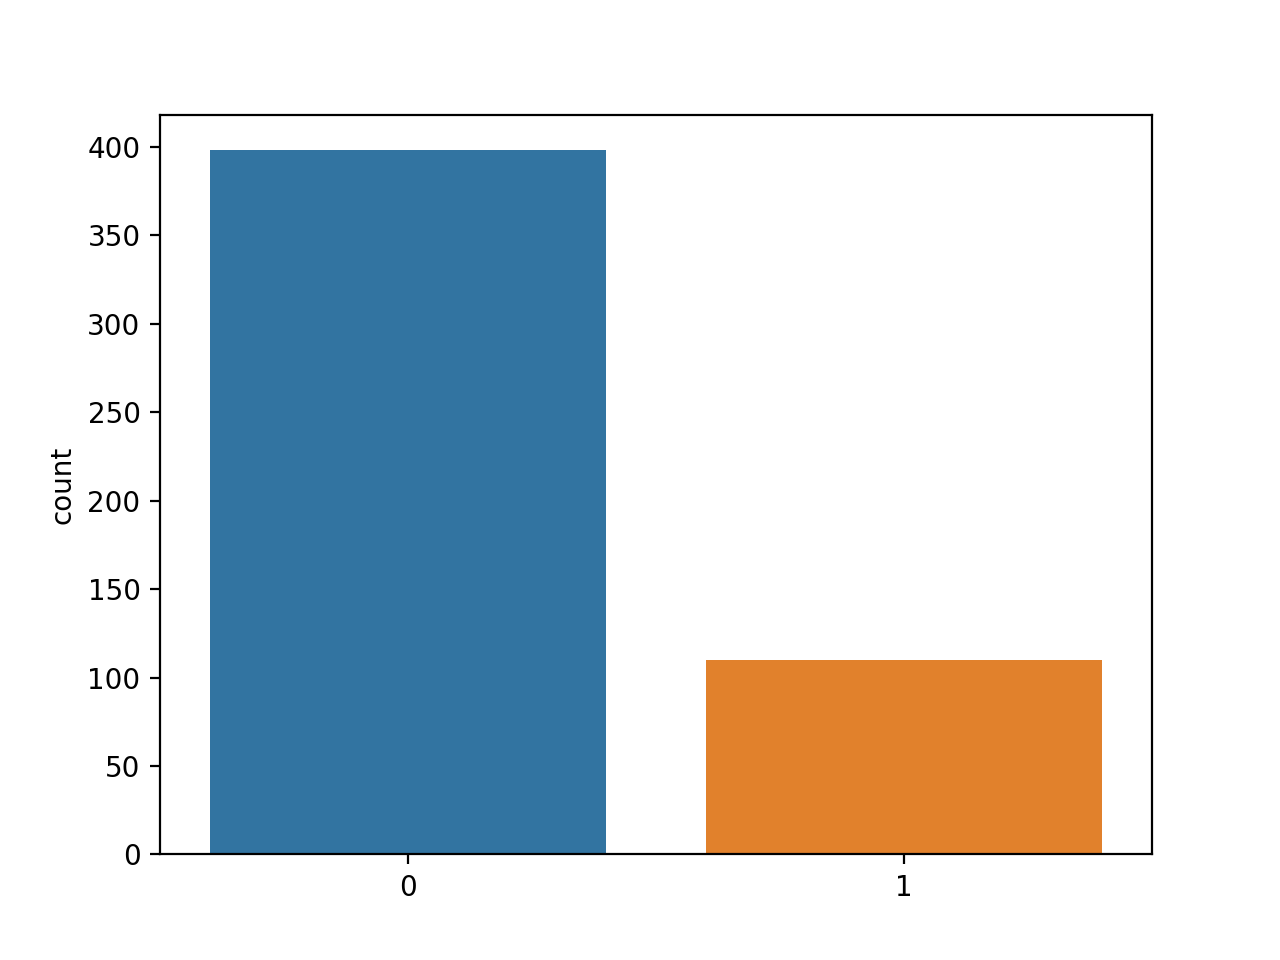

In [51]:
# test_wav_dir = r"C:\Users\AKMAHAJA\Workspace\Hack\PodCast\data\Test\OrcasoundLab07052019_Test\wav"
# test_tsv_file = r"C:\Users\AKMAHAJA\Workspace\Hack\PodCast\data\Test\OrcasoundLab07052019_Test\test.tsv"

test_wav_dir = r"C:\Users\AKMAHAJA\Workspace\Hack\PodCast\data\Test\OrcasoundLab09272017_Test\wav"
test_tsv_file = r"C:\Users\AKMAHAJA\Workspace\Hack\PodCast\data\Test\OrcasoundLab09272017_Test\test.tsv"

mean_file = r"C:\Users\AKMAHAJA\Workspace\Hack\PodCast\data\TrainAll\mean64.txt"
invstd_file = r"C:\Users\AKMAHAJA\Workspace\Hack\PodCast\data\TrainAll\invstd64.txt"

test_dataset = src.dataloader.AudioFileDataset(
    test_wav_dir, test_tsv_file, mean=mean_file, invstd=invstd_file
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=False)
print("Total dataset size:",len(test_dataset))
labels = [l[2] for l in test_dataset.windows]
sns.countplot(labels)

In [61]:
# run_dir = r"C:\Users\AKMAHAJA\Workspace\Hack\orcaml\podcast_ml\runs\AudioSet_fc_all_lr0.0005_run2"
# run_dir = r"C:\Users\AKMAHAJA\Workspace\Hack\orcaml\podcast_ml\runs\AudioSet_fc_all_lr0.0005_run1.1"
run_dir = r"C:\Users\AKMAHAJA\Workspace\Hack\orcaml\podcast_ml\runs\AudioSet_fc_all_lr0.0005_run3.3"
# net, curr_epoch = src.model.get_model_or_checkpoint("AudioSet_fc_all", run_dir, epoch=16)
net, curr_epoch = src.model.get_model_or_checkpoint("AudioSet_fc_all", run_dir, average_models=True)

net = net.eval()
preds = []
scores = []
targets = []

for i, (data,target) in enumerate(test_dataloader):
    data, target = data.unsqueeze(1).float().cuda(), target.cuda() 
    logposterior, _ = net(data)
    scores.append(np.exp(logposterior.detach().cpu().numpy())[0,-1])
    targets.append(target.cpu().item())

Averaging 4 checkpoints
['C:\\Users\\AKMAHAJA\\Workspace\\Hack\\orcaml\\podcast_ml\\runs\\AudioSet_fc_all_lr0.0005_run3.3\\AudioSet_fc_all_Iter_8', 'C:\\Users\\AKMAHAJA\\Workspace\\Hack\\orcaml\\podcast_ml\\runs\\AudioSet_fc_all_lr0.0005_run3.3\\AudioSet_fc_all_Iter_6', 'C:\\Users\\AKMAHAJA\\Workspace\\Hack\\orcaml\\podcast_ml\\runs\\AudioSet_fc_all_lr0.0005_run3.3\\AudioSet_fc_all_Iter_4', 'C:\\Users\\AKMAHAJA\\Workspace\\Hack\\orcaml\\podcast_ml\\runs\\AudioSet_fc_all_lr0.0005_run3.3\\AudioSet_fc_all_Iter_2']


In [64]:
torch.save(net.state_dict(), r"C:\Users\AKMAHAJA\Workspace\Hack\orcaml\podcast_ml\runs\ModelAverage\AudioSet_fc_all_round3")

In [62]:
fpr, tpr, thresholds = metrics.roc_curve(targets,scores)
auc = metrics.auc(fpr,tpr)
print("AUC: {:.3f}".format(auc))

AUC: 0.912


<IPython.core.display.Javascript object>


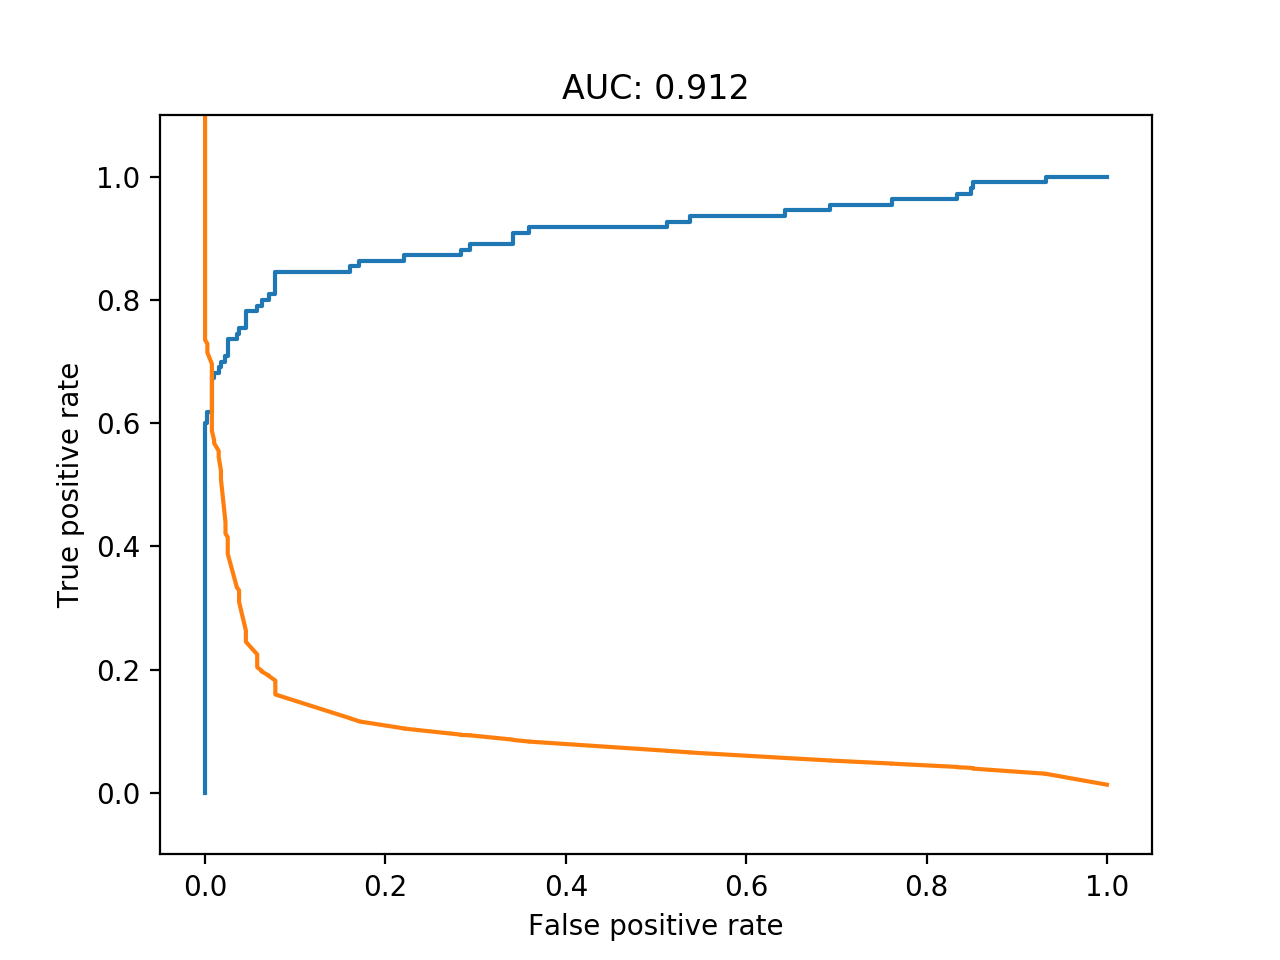

In [63]:
%matplotlib notebook
plt.plot(fpr,tpr)
plt.plot(fpr,thresholds)
plt.ylim((-0.1,1.1))
_ = plt.xlabel("False positive rate")
_ = plt.ylabel("True positive rate")
_ = plt.title("AUC: {:.3f}".format(auc))

In [55]:
threshold = 0.5 # threshold to pick when generating annotation candidates
preds = [ 1 if s > threshold else 0 for s in scores ]
print(metrics.classification_report(targets,preds))
print(metrics.confusion_matrix(targets,preds))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       398
           1       0.92      0.70      0.79       110

   micro avg       0.92      0.92      0.92       508
   macro avg       0.92      0.84      0.87       508
weighted avg       0.92      0.92      0.92       508

[[391   7]
 [ 33  77]]
